## Explore map

Este codigo explora un rectangulo y obtiene todos los posibles negocios en el area minimizando el numero de consultas

Disclaimer: mientras mas pequeño el radio de los circulos se logra mejor cobertura del mapa pero tambien aumenta el numero de consultas a la API

### Librerias necesarias 
folium geopandas shapely.geometry matplotlib 

In [1]:
from config import interim_path

ModuleNotFoundError: No module named 'config'

In [2]:
import folium
import math
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [3]:
"""Esta funcion recibe un rango de latitudes y longitudes y un radio de busqueda
y devuelve los puntos del mapa que minimizan el numero de consultas a la API de Google Places.

Para ello dividimos el mapa en una reticula hexagonal donde R sera la distacia del centro al vertice
de cada hexagono.
"""

def get_zones(R, lat_i, lat_f, lon_i, lon_f):
   
    dx = R * math.sqrt(3)  # distancia entre centros en la misma fila (horizontal)
    dy = 1.5 * R     # distancia vertical entre centros en filas alternadas

    zones = []

    lat = lat_i
    row = 0
    while lat <= lat_f:
        # desplazamiento en columnas: pares sin offset, impares con dx/2
        offset = 0 if row % 2 == 0 else dx / 2
        lon = lon_i + offset

        while lon <= lon_f:
            zones.append((lat, lon))
            lon += dx

        lat += dy
        row += 1

    return zones

In [3]:
# Parámetros
R = 0.01  # Aproximadamente 1 km entre centros
lat_i, lat_f = 40.48, 40.92
lon_i, lon_f = -74.28, -73.7

centros = get_zones(R, lat_i, lat_f, lon_i, lon_f)

C:\Users\NoxiePC\AppData\Local\Temp\ipykernel_16428\3858780824.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within_nyc = points_gdf[points_gdf.within(nyc.unary_union)]


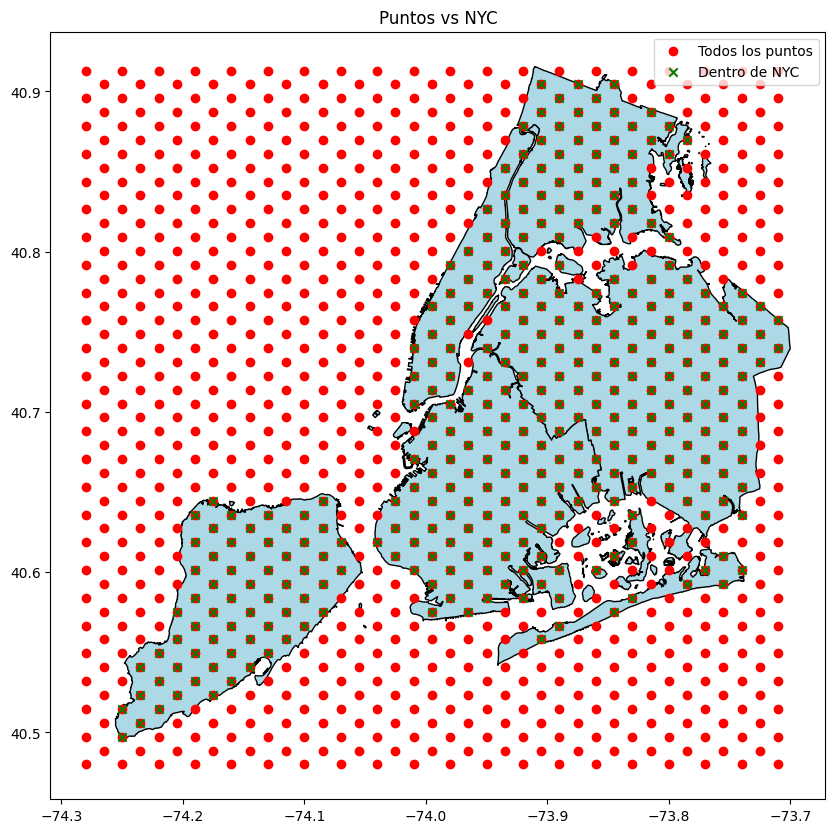

In [4]:
centros = get_zones(R, lon_i, lon_f, lat_i, lat_f)
# Cargar y transformar shapefile
nyc = gpd.read_file("../assets/nybb.shp").to_crs(epsg=4326)

# Crear GeoDataFrame de centros
points_gdf = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lon, lat in centros],  # lon, lat está bien
    crs="EPSG:4326"
)

# Ver qué puntos están dentro
points_within_nyc = points_gdf[points_gdf.within(nyc.unary_union)]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
nyc.plot(ax=ax, color='lightblue', edgecolor='black')
points_gdf.plot(ax=ax, color='red', marker='o', label='Todos los puntos')
points_within_nyc.plot(ax=ax, color='green', marker='x', label='Dentro de NYC')
plt.legend()
plt.title("Puntos vs NYC")
plt.show()


In [6]:
m = folium.Map(location=[(lat_i + lat_f) / 2, (lon_i + lon_f) / 2], zoom_start=12)

# Dibujar un círculo de 1 km sobre cada punto
for point in points_within_nyc.geometry:
    folium.Circle(
        location=[point.y, point.x],  # lat, lon
        radius=1000,  # metros
        color='red',
        fill=True,
        fill_opacity=0.3
    ).add_to(m)

m


In [15]:
import requests

def obtener_restaurantes_osm_2(lat, lon, radio=200):
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    query = f"""
    [out:json];
    node
      ["amenity"="restaurant"]
      (around:{radio},{lat},{lon});
    out;
    """

    try:
        response = requests.get(overpass_url, params={'data': query}, timeout=30)
        data = response.json()

        restaurantes = []
        for element in data['elements']:
            tags = element.get('tags', {})

            restaurante = {
                "gmap_id": element.get('id'),  # no es Google, pero usamos el ID de OSM
                "name": tags.get('name', 'Sin nombre'),
                "address": f"{tags.get('addr:street', '')} {tags.get('addr:housenumber', '')}".strip() or "Desconocida",
                "description": tags.get('description', 'Sin descripción'),
                "latitude": element.get('lat'),
                "longitude": element.get('lon'),
                "category": [tags.get('amenity', 'restaurant')],
                "avg_rating": None,  # No disponible en OSM
                "num_of_reviews": None,  # No disponible en OSM
                "price": tags.get('price', None),  # puede estar como etiqueta custom
                "hours": tags.get('opening_hours', None),
                "MISC": {
                    "cuisine": tags.get('cuisine', None),
                    "wheelchair": tags.get('wheelchair', None),
                    "takeaway": tags.get('takeaway', None),
                    "delivery": tags.get('delivery', None),
                    "website": tags.get('website', None)
                },
                "state": tags.get('addr:state', None),
                "relative_results": None,
                "url": tags.get('website', None)
            }

            restaurantes.append(restaurante)

        return restaurantes
    
    except Exception as e:
        print(f"Error en ({lat}, {lon}): {e}")
        return []


In [1]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import time
import random

# Función para consultar restaurantes en un radio (en metros) usando Overpass API
def obtener_restaurantes_osm(lat, lon, radio=200):
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    query = f"""
    [out:json];
    node
      ["amenity"="restaurant"]
      (around:{radio},{lat},{lon});
    out;
    """

    try:
        response = requests.get(overpass_url, params={'data': query}, timeout=30)
        data = response.json()

        restaurantes = []
        for element in data['elements']:
            restaurantes.append({
                'nombre': element.get('tags', {}).get('name', 'Sin nombre'),
                'lat': element['lat'],
                'lon': element['lon'],
                'cuisine': element.get('tags', {}).get('cuisine', 'No especificado'),
                'direccion': element.get('tags', {}).get('addr:street', 'Desconocida'),
                'origen_lat': lat,
                'origen_lon': lon
            })

        return restaurantes
    
    except Exception as e:
        print(f"Error en ({lat}, {lon}): {e}")
        return []

# Asumiendo que ya tenés tu GeoDataFrame "points_gdf"
# Ejemplo de cómo se vería:
# points_gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in centros], crs="EPSG:4326")

resultados = []

for punto in points_within_nyc.geometry:
    lon, lat = punto.x, punto.y
    data = obtener_restaurantes_osm_2(lat, lon, radio=200)
    resultados.extend(data)
    
    time.sleep(random.uniform(1, 2))  # espera entre requests para no abusar

# Convertir resultados a DataFrame y guardar
df = pd.DataFrame(resultados)
df.to_csv("restaurantes_osm_desde_centros.csv", index=False)
print("Listo. Restaurantes guardados en CSV.")


NameError: name 'points_within_nyc' is not defined

In [8]:
# Convertir resultados a DataFrame y guardar
df = pd.DataFrame(resultados)
df.to_csv("restaurantes_osm_desde_centros.csv", index=False)
print("Listo. Restaurantes guardados en CSV.")


NameError: name 'pd' is not defined

In [11]:
import pandas as pd
df = pd.read_csv("restaurantes_osm_desde_centros.csv")

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6708 entries, 0 to 8533
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gmap_id           6708 non-null   int64  
 1   name              6708 non-null   object 
 2   address           6708 non-null   object 
 3   description       6708 non-null   object 
 4   latitude          6708 non-null   float64
 5   longitude         6708 non-null   float64
 6   category          6708 non-null   object 
 7   avg_rating        0 non-null      float64
 8   num_of_reviews    0 non-null      float64
 9   price             0 non-null      float64
 10  hours             3285 non-null   object 
 11  MISC              6708 non-null   object 
 12  state             1876 non-null   object 
 13  relative_results  0 non-null      float64
 14  url               3279 non-null   object 
dtypes: float64(6), int64(1), object(8)
memory usage: 838.5+ KB


In [14]:
df = df.drop_duplicates(subset=["name", "address", "latitude", "longitude"])
